# Nbody simulation

Get Acceleration:

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output

"""
Create Your Own N-body Simulation (With Python)
Philip Mocz (2020) Princeton Univeristy, @PMocz
Simulate orbits of stars interacting due to gravity
Code calculates pairwise forces according to Newton's Law of Gravity
"""

def getAcc( pos, mass, G, softening ):
	"""
    Calculate the acceleration on each particle due to Newton's Law 
	pos  is an N x 3 matrix of positions
	mass is an N x 1 vector of masses
	G is Newton's Gravitational constant
	softening is the softening length
	a is N x 3 matrix of accelerations
	"""
	# positions r = [x,y,z] for all particles
	x = pos[:,0:1]
	y = pos[:,1:2]
	z = pos[:,2:3]

	# matrix that stores all pairwise particle separations: r_j - r_i
	dx = x.T - x
	dy = y.T - y
	dz = z.T - z

	# matrix that stores 1/r^3 for all particle pairwise particle separations 
	inv_r3 = (dx**2 + dy**2 + dz**2 + softening**2)
	inv_r3[inv_r3>0] = inv_r3[inv_r3>0]**(-1.5)

	ax = G * (dx * inv_r3) @ mass
	ay = G * (dy * inv_r3) @ mass
	az = G * (dz * inv_r3) @ mass
	
	# pack together the acceleration components
	a = np.hstack((ax,ay,az))

	return a

## Energy:

In [39]:
def getEnergy( pos, vel, mass, G ):
	"""
	Get kinetic energy (KE) and potential energy (PE) of simulation
	pos is N x 3 matrix of positions
	vel is N x 3 matrix of velocities
	mass is an N x 1 vector of masses
	G is Newton's Gravitational constant
	KE is the kinetic energy of the system
	PE is the potential energy of the system
	"""
	# Kinetic Energy:
	KE = 0.5 * np.sum(np.sum( mass * vel**2 ))


	# Potential Energy:

	# positions r = [x,y,z] for all particles
	x = pos[:,0:1]
	y = pos[:,1:2]
	z = pos[:,2:3]

	# matrix that stores all pairwise particle separations: r_j - r_i
	dx = x.T - x
	dy = y.T - y
	dz = z.T - z

	# matrix that stores 1/r for all particle pairwise particle separations 
	inv_r = np.sqrt(dx**2 + dy**2 + dz**2)
	inv_r[inv_r>0] = 1.0/inv_r[inv_r>0]

	# sum over upper triangle, to count each interaction only once
	PE = G * np.sum(np.sum(np.triu(-(mass*mass.T)*inv_r,1)))
	
	return KE, PE;


Main simulation:

In [42]:

def main():
	""" N-body simulation """
	
	# Simulation parameters
	N         = 100    # Number of particles
	t         = 0      # current time of the simulation
	tEnd      = 10.0   # time at which simulation ends
	dt        = 0.01   # timestep
	softening = 0.1    # softening length
	G         = 1.0    # Newton's Gravitational Constant
	plotRealTime = True # switch on for plotting as the simulation goes along
	
	# Generate Initial Conditions
	np.random.seed(17)            # set the random number generator seed
	
	mass = 20.0*np.ones((N,1))/N  # total mass of particles is 20
	pos  = np.random.randn(N,3)   # randomly selected positions and velocities
	vel  = np.random.randn(N,3)
	
	# Convert to Center-of-Mass frame
	vel -= np.mean(mass * vel,0) / np.mean(mass)
	
	# calculate initial gravitational accelerations
	acc = getAcc( pos, mass, G, softening )
	
	# calculate initial energy of system
	KE, PE  = getEnergy( pos, vel, mass, G )
	
	# number of timesteps
	Nt = int(np.ceil(tEnd/dt))
	
	# save energies, particle orbits for plotting trails
	pos_save = np.zeros((N,3,Nt+1))
	pos_save[:,:,0] = pos
	'''
	KE_save = np.zeros(Nt+1)
	KE_save[0] = KE
	PE_save = np.zeros(Nt+1)
	PE_save[0] = PE
	t_all = np.arange(Nt+1)*dt
	'''

	# prep figure
	fig = plt.figure(figsize=(4,5), dpi=80)
	grid = plt.GridSpec(3, 1, wspace=0.0, hspace=0.3)
	ax1 = plt.subplot(grid[0:2,0])
	ax2 = plt.subplot(grid[2,0])
	
	# Simulation Main Loop
	for i in range(Nt):
		# (1/2) kick
		vel += acc * dt/2.0
		
		# drift
		pos += vel * dt
		
		# update accelerations
		acc = getAcc( pos, mass, G, softening )
		
		# (1/2) kick
		vel += acc * dt/2.0
		
		# update time
		t += dt
		
		# get energy of system
		KE, PE  = getEnergy( pos, vel, mass, G )
		
		
		# save energies, positions for plotting trail
		pos_save[:,:,i+1] = pos
		'''
		KE_save[i+1] = KE
		PE_save[i+1] = PE
		'''
		
		# plot in real time
		if plotRealTime or (i == Nt-1):
			plt.sca(ax1)
			plt.cla()
			xx = pos_save[:,0,max(i-50,0):i+1]
			yy = pos_save[:,1,max(i-50,0):i+1]
			plt.scatter(xx,yy,s=1,color=[.7,.7,1])
			plt.scatter(pos[:,0],pos[:,1],s=10,color='blue')
			ax1.set(xlim=(-2, 2), ylim=(-2, 2))
			ax1.set_aspect('equal', 'box')
			ax1.set_xticks([-2,-1,0,1,2])
			ax1.set_yticks([-2,-1,0,1,2])

			


			'''
			plt.sca(ax2)
			plt.cla()
			plt.scatter(t_all,KE_save,color='red',s=1,label='KE' if i == Nt-1 else "")
			plt.scatter(t_all,PE_save,color='blue',s=1,label='PE' if i == Nt-1 else "")
			plt.scatter(t_all,KE_save+PE_save,color='black',s=1,label='Etot' if i == Nt-1 else "")
			ax2.set(xlim=(0, tEnd), ylim=(-300, 300))
			ax2.set_aspect(0.007)
			'''
			plt.pause(0.001)

	
	# add labels/legend
	plt.sca(ax2)
	plt.xlabel('time')
	plt.ylabel('energy')
	ax2.legend(loc='upper right')
	
	# Save figure
	plt.savefig('nbody.png',dpi=240)
	plt.show()

	clear_output(wait=True)
	time.sleep(0.0001)
	
	return 0

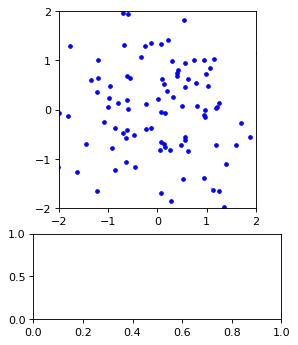

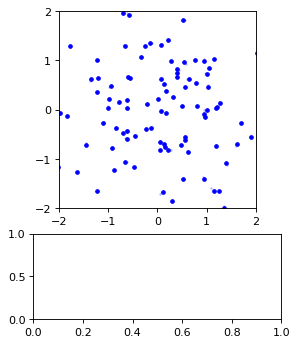

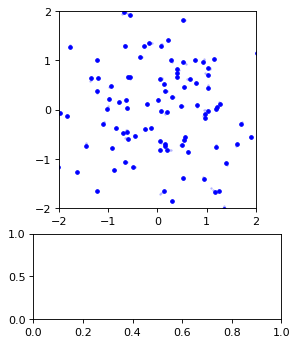

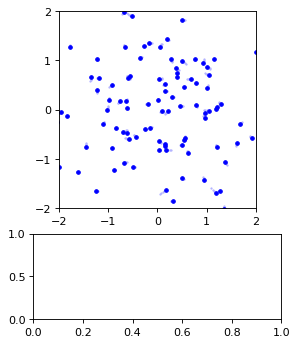

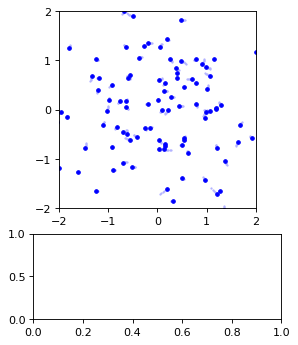

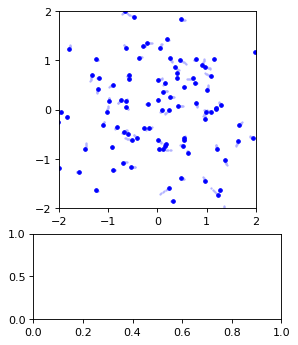

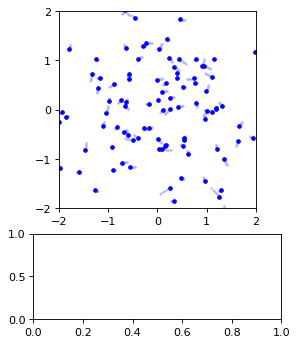

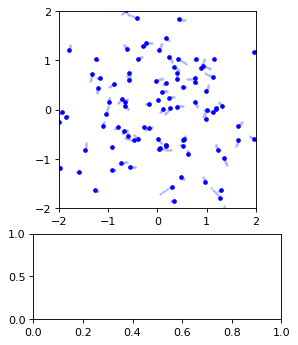

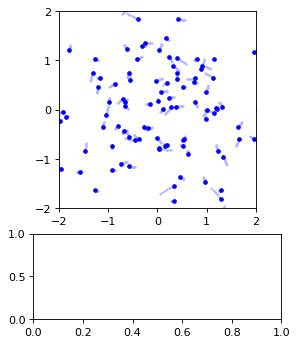

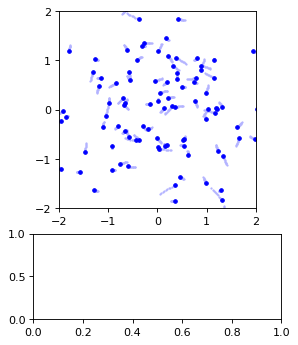

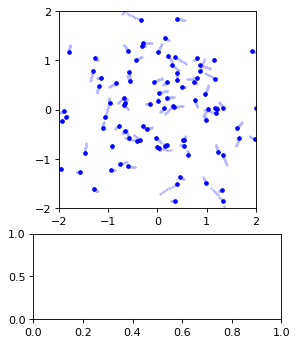

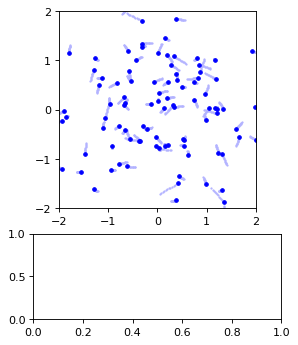

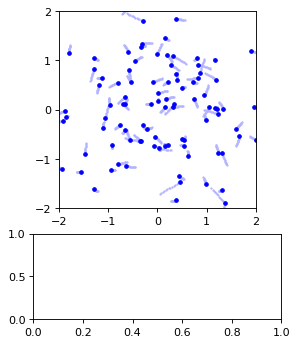

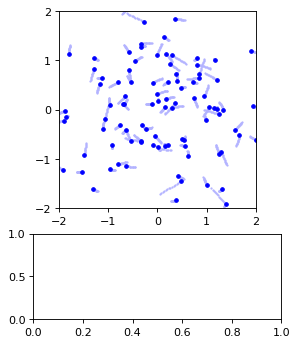

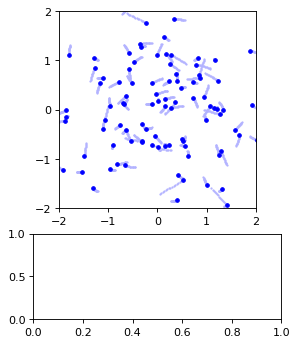

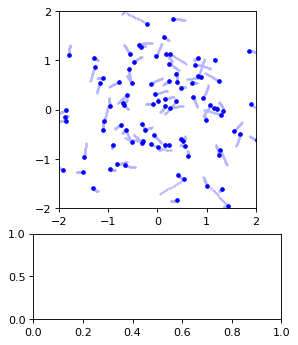

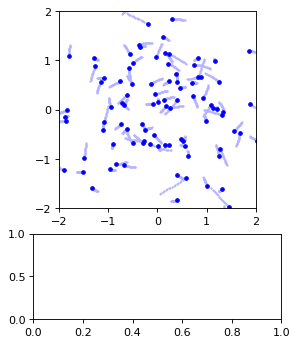

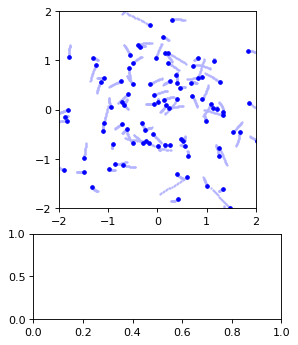

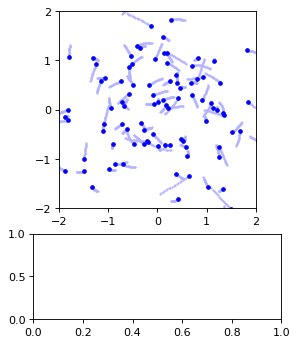

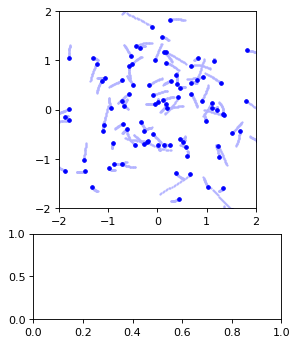

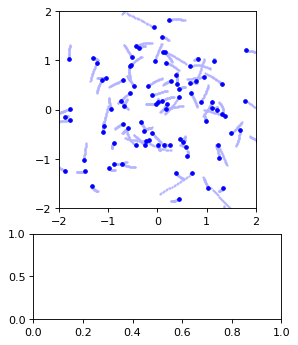

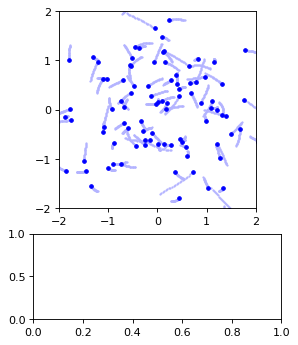

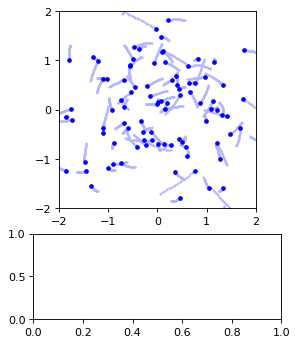

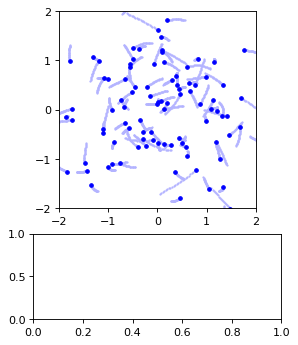

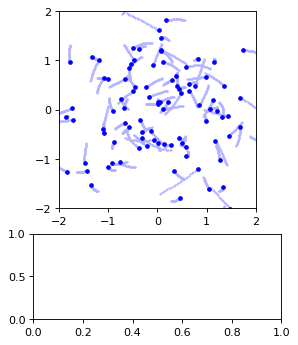

In [43]:
main()